In [1]:
# import libraries
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division

#import plotly.plotly as py
#import plotly.offline as pyoff
#import plotly.graph_objs as go

#inititate Plotly
#pyoff.init_notebook_mode()
import pyodbc
server = 'xilnex-venus.database.windows.net'
database = 'XilnexDB124'
username = 'supportdata@xilnex-venus'
password = '@letmeverify1st@'
driver= '{ODBC Driver 17 for SQL Server}'

query = "SELECT * FROM COM_1617.ETL_90011"
conn = pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password)
online = pd.read_sql_query(query,conn)


# Convert InvoiceDate from object to datetime format
#online = pd.read_csv('C:/Users/kjx_9/PycharmProjects/pythonProject/data.csv', encoding="ISO-8859-1")
online['Date'] = pd.to_datetime(online['Date'])
online = online[online['Client ID'] != '']
online['TotalSum'] = online['Sales Amount']
#online = online['TotalSum'] > 0

# Create snapshot date
snapshot_date = online['Date'].max() + timedelta(days=1)
#print(snapshot_date)
# Grouping by CustomerID
rfm_df = online.groupby(['Client ID']).agg({
        'Date': lambda x: (snapshot_date - x.max()).days, #Get recency
        'Client ID': 'count',
        'TotalSum': 'sum'})
# Rename the columns
rfm_df.rename(columns={'Date': 'Recency',
                         'Client ID': 'Frequency',
                         'TotalSum': 'Monetary'}, inplace=True)


In [2]:
print(rfm_df)
rfm_df['Recency'].describe()
print(online)


           Recency  Frequency  Monetary
Client ID                              
11301          221          3    700.45
113010        1248          1      0.00
1130100       1097          1      0.00
11301000       764          1     26.00
11301001       764          1     29.90
...            ...        ...       ...
970995         224          1     74.00
970996         224          1    114.75
970997         224          1     82.80
970998         224          1     82.80
970999         224          1     82.75

[125482 rows x 3 columns]
        ID       Date      Location Client ID  Year Month  Sales Amount  \
2        2 2014-05-19  12 - AEON S2    408936  2014   May         44.55   
3        3 2014-05-19  12 - AEON S2   4014294  2014   May        287.90   
4        4 2014-05-19  12 - AEON S2   4014992  2014   May         39.70   
5        5 2014-05-19  12 - AEON S2   4019705  2014   May        137.16   
6        6 2014-05-19  12 - AEON S2   4049588  2014   May         67.08   
...

C:\Users\kjx_9\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\kjx_9\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\kjx_9\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

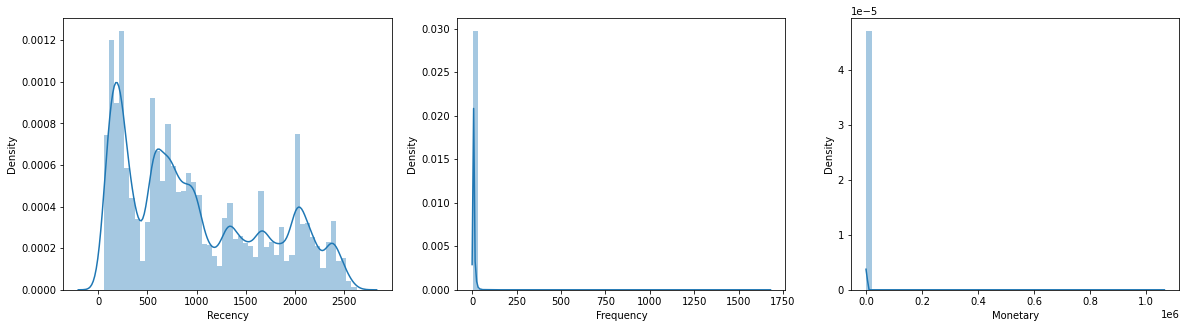

In [3]:
#plot bar chart
fig,axes = plt.subplots(1,3, figsize=(20,5))

for i, feature in enumerate(list(rfm_df.columns)):
    sns.distplot(rfm_df[feature],ax=axes[i])

<ipython-input-4-2c661f9e143d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_recency["clusters"] = kmeans.labels_
<ipython-input-4-2c661f9e143d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_recency["clusters"] = kmeans.labels_
<ipython-input-4-2c661f9e143d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

{1: 63942710857.215096, 2: 14243284852.478058, 3: 6702683324.973919, 4: 3231607439.465932, 5: 2143065142.9406366, 6: 1449269506.2253504, 7: 1029140983.2784197, 8: 799595218.1328388, 9: 619576353.2062737}


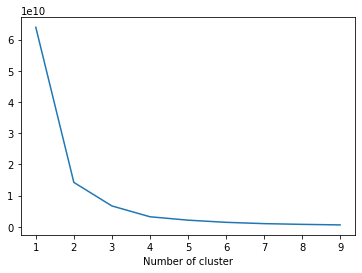

In [4]:
from sklearn.cluster import KMeans
tx_user = rfm_df
sse={}
tx_recency = rfm_df[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
print(sse)
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [5]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])


#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

tx_user['RecencyCluster'] =tx_user['RecencyCluster'].apply(lambda x: x + 1)

In [6]:

print(tx_user[["Recency", "RecencyCluster"]].groupby('RecencyCluster').describe())
print(tx_user)

                Recency                                                   \
                  count         mean         std     min     25%     50%   
RecencyCluster                                                             
1               23539.0  2142.282255  194.398404  1806.0  2008.0  2106.0   
2               21775.0  1468.072698  190.757227  1116.0  1317.0  1460.0   
3               43253.0   762.103669  167.834619   501.0   603.0   741.0   
4               36915.0   213.786428   94.750074     1.0   133.0   211.0   

                                
                   75%     max  
RecencyCluster                  
1               2335.0  2628.0  
2               1651.0  1805.0  
3                910.0  1115.0  
4                273.0   453.0  
        Recency  Frequency  Monetary  RecencyCluster
0           221          3    700.45               4
1           309          4    210.00               4
2           127          8    705.10               4
3           281         

In [7]:
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

#order the frequency cluster
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)
tx_user['FrequencyCluster'] =tx_user['FrequencyCluster'].apply(lambda x: x + 1)
#see details of each cluster
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
1,111689.0,1.940030,1.357833,1.0,1.0,1.0,2.0,6.0
2,13093.0,11.355610,4.620491,7.0,8.0,10.0,13.0,27.0
3,697.0,42.680057,22.812632,28.0,30.0,35.0,46.0,275.0
4,3.0,1237.333333,494.202725,703.0,1017.0,1331.0,1504.5,1678.0


In [8]:

print(tx_user[["Frequency", "FrequencyCluster"]].groupby('FrequencyCluster').describe())
print(tx_user)

                 Frequency                                                  \
                     count         mean         std    min     25%     50%   
FrequencyCluster                                                             
1                 111689.0     1.940030    1.357833    1.0     1.0     1.0   
2                  13093.0    11.355610    4.620491    7.0     8.0    10.0   
3                    697.0    42.680057   22.812632   28.0    30.0    35.0   
4                      3.0  1237.333333  494.202725  703.0  1017.0  1331.0   

                                  
                     75%     max  
FrequencyCluster                  
1                    2.0     6.0  
2                   13.0    27.0  
3                   46.0   275.0  
4                 1504.5  1678.0  
        Recency  Frequency    Monetary  RecencyCluster  FrequencyCluster
0           221          3      700.45               4                 1
1           309          4      210.00               4        

In [9]:
#apply clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Monetary']])
tx_user['MonetaryCluster'] = kmeans.predict(tx_user[['Monetary']])


#order the cluster numbers
tx_user = order_cluster('MonetaryCluster', 'Monetary',tx_user,True)
tx_user['MonetaryCluster'] =tx_user['MonetaryCluster'].apply(lambda x: x + 1)
#show details of the dataframe
tx_user.groupby('MonetaryCluster')['Monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
MonetaryCluster,,,,,,,,
1,125476.0,3.350049e+02,576.027682,0.00,7.980000e+01,161.025,3.695000e+02,35527.70
2,2.0,1.386864e+05,45393.179438,106588.62,1.226375e+05,138686.445,1.547354e+05,170784.27
3,3.0,4.547608e+05,90515.166677,371647.49,4.065410e+05,441434.460,4.963174e+05,551200.30
4,1.0,1.063686e+06,NaN,1063686.49,1.063686e+06,1063686.490,1.063686e+06,1063686.49


In [10]:
print(tx_user[["Monetary", "MonetaryCluster"]].groupby('MonetaryCluster').describe())
print(tx_user)

                 Monetary                                          \
                    count          mean           std         min   
MonetaryCluster                                                     
1                125476.0  3.350049e+02    576.027682        0.00   
2                     2.0  1.386864e+05  45393.179438   106588.62   
3                     3.0  4.547608e+05  90515.166677   371647.49   
4                     1.0  1.063686e+06           NaN  1063686.49   

                                                                      
                          25%          50%           75%         max  
MonetaryCluster                                                       
1                7.980000e+01      161.025  3.695000e+02    35527.70  
2                1.226375e+05   138686.445  1.547354e+05   170784.27  
3                4.065410e+05   441434.460  4.963174e+05   551200.30  
4                1.063686e+06  1063686.490  1.063686e+06  1063686.49  
        Recency  Fr

In [11]:
#calculate overall score and use mean() to see details
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['MonetaryCluster']
print(tx_user)
#tx_user.groupby('OverallScore')['Recency','Frequency','Monetary'].mean()

        Recency  Frequency    Monetary  RecencyCluster  FrequencyCluster  \
0           221          3      700.45               4                 1   
1           309          4      210.00               4                 1   
2            91          2       62.90               4                 1   
3           201          3      109.70               4                 1   
4           434          3      130.65               4                 1   
...         ...        ...         ...             ...               ...   
125477        1        703   106588.62               4                 4   
125478       26         29   441434.46               4                 3   
125479       26         28   371647.49               4                 3   
125480        1       1331   551200.30               4                 4   
125481        1       1678  1063686.49               4                 4   

        MonetaryCluster  OverallScore  
0                     1             6  
1      

In [12]:
#apply clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['OverallScore']])
tx_user['OverallScoreFinal'] = kmeans.predict(tx_user[['OverallScore']])


#order the cluster numbers
tx_user = order_cluster('OverallScoreFinal', 'OverallScore',tx_user,True)
tx_user['OverallScoreFinal'] =tx_user['OverallScoreFinal'].apply(lambda x: x + 1)
#show details of the dataframe
tx_user.groupby('OverallScoreFinal')['OverallScore'].describe()

,count,mean,std,min,25%,50%,75%,max
OverallScoreFinal,,,,,,,,
1,22666.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
2,21044.0,4.000000,0.000000,4.0,4.0,4.0,4.0,4.0
3,39787.0,5.000000,0.000000,5.0,5.0,5.0,5.0,5.0
4,41985.0,6.165773,0.406403,6.0,6.0,6.0,6.0,12.0


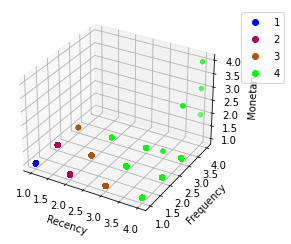

In [13]:
# k mean clustering  on each column then use the sum of the score compute as overallscore then compute k mean again on the score to get the overallfinalscore as legend
#plotting is base on clustering value
fig=plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

sc = ax.scatter(tx_user['RecencyCluster'],tx_user['FrequencyCluster'],tx_user['MonetaryCluster'],cmap="brg",c=tx_user['OverallScoreFinal'])
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

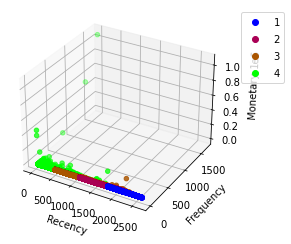

In [14]:
# k mean clustering  on each column then use the sum of the score compute as overallscore then compute k mean again on the score to get the overallfinalscore as legend
#plotting is base on original value
fig=plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

sc = ax.scatter(tx_user['Recency'],tx_user['Frequency'],tx_user['Monetary'],cmap="brg",c=tx_user['OverallScoreFinal'])
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

,Recency,Frequency,Monetary
count,125482.000000,125482.000000,125482.000000
mean,0.373510,0.001299,0.000335
std,0.271736,0.004773,0.003608
min,0.000000,0.000000,0.000000
25%,0.124096,0.000000,0.000075
50%,0.304149,0.000596,0.000151
75%,0.593833,0.001193,0.000347
max,1.000000,1.000000,1.000000


         Recency  Frequency  Monetary
0       0.083746   0.001193  0.000659
1       0.117244   0.001789  0.000197
2       0.034260   0.000596  0.000059
3       0.076132   0.001193  0.000103
4       0.164827   0.001193  0.000123
...          ...        ...       ...
125477  0.897982   0.000000  0.000105
125478  0.947849   0.001789  0.000509
125479  0.890750   0.000000  0.000028
125480  0.772745   0.000000  0.000084
125481  0.771983   0.001193  0.000508

[125482 rows x 3 columns]
[[2.89795110e-01 1.27242798e-03 3.09304769e-04]
 [5.58748566e-01 9.89265370e-04 2.39502060e-04]
 [8.09997824e-02 1.89896191e-03 4.90703556e-04]
 [8.15241640e-01 6.92466088e-04 2.27363762e-04]]


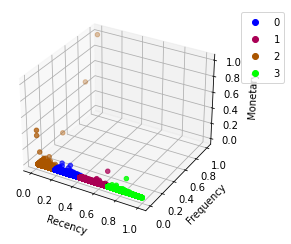

In [15]:
# normalized and do k mean clustering
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

user = tx_user[['Recency','Frequency','Monetary']]

rfm_normalized = pd.DataFrame(scaler.fit_transform(user))
rfm_normalized.columns = ['Recency','Frequency','Monetary']
display(rfm_normalized.describe())
print(rfm_normalized)

model = KMeans(n_clusters =4, random_state =1231).fit(rfm_normalized)

centers = model.cluster_centers_
print(model.cluster_centers_)
fig=plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
sc = ax.scatter(rfm_normalized['Recency'],rfm_normalized['Frequency'],rfm_normalized['Monetary'],cmap="brg",c=model.predict(rfm_normalized))
ax.scatter(centers[:,0],centers[:,1],c='black')
plt.legend(*sc.legend_elements(),bbox_to_anchor=(1.05, 1), loc=2)